- environment setup

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

pd.plotting.register_matplotlib_converters()

# Goal: Uncover any anomalies in the web pages accessed by each user



## Wrangle

In [2]:
colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
# specify column names

df = pd.read_csv("anonymized-curriculum-access.txt", 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 2, 3, 4, 5])
# acquire data from document

df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
df.date = pd.to_datetime(df.date)
# convert date column into a time series

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       900223 non-null  datetime64[ns]
 1   endpoint   900222 non-null  object        
 2   user_id    900223 non-null  int64         
 3   cohort_id  847330 non-null  float64       
 4   source_ip  900223 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 34.3+ MB


In [5]:
df.shape

(900223, 5)

In [6]:
df.describe()

,user_id,cohort_id
count,900223.000000,847330.000000
mean,458.825707,48.501049
std,249.296767,32.795482
min,1.000000,1.000000
25%,269.000000,28.000000
50%,475.000000,33.000000
75%,660.000000,57.000000
max,981.000000,139.000000


In [7]:
df.isnull().sum()

date             0
endpoint         1
user_id          0
cohort_id    52893
source_ip        0
dtype: int64

In [8]:
df = df.set_index(df.date)
# set date to index for use in time series operations

In [9]:
df.head()

,date,endpoint,user_id,cohort_id,source_ip
date,,,,,
2018-01-26,2018-01-26,/,1,8.0,97.105.19.61
2018-01-26,2018-01-26,java-ii,1,8.0,97.105.19.61
2018-01-26,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [10]:
pages = df['endpoint'].resample('D').count()
# make a seperate df that counts how many times the curriculum gets accessed in a day

In [11]:
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

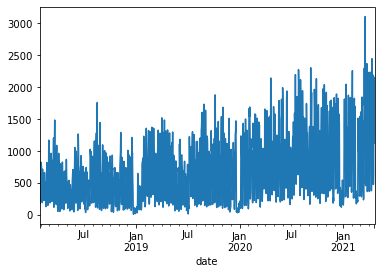

In [12]:
pages.plot()
# visualize distribution

### Takeaways

- sharp dip every December, likely holidays

- small shard dip Feb 2021, that was the ice storm that made class cancelled for a week

- periodic sharp spikes, capstones?

- requests for curriculum pages has grown gradually over time 

In [13]:
pages.isnull().sum()

0

## Exponential Moving Average

- find the exponential moving average of various timeframes to detect recent spikes that could be considered anomalies

In [14]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

In [15]:
# 14 day EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [16]:
# 30 day EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [17]:
# 90 day EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

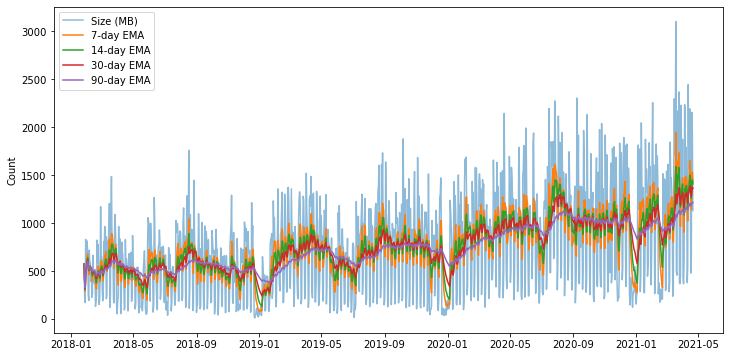

In [18]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Size (MB)', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Count')

plt.show()

# visualize EMA graphs together 

### Takeaways

- We still see the same peaks and valleys in the various EMAs, however they are less dramatic

## Bollinger Bands and %b

#### Bollinger Bands
- indicates volatility in data trends

#### Midband
- the chosen EMA

#### Upper and Lower Band 
- instances when the observations exceed the upper or lower band are considered anomalies
- UB/LB = Midband +/- stdev * K
-- K = how many std dev you wish to measure 
-- weight applied the band

#### %b, Percent Bandwidth
- where the final value sits between the bands
- < 0, below the lower band
- > 1, abover the upper band
-- anything above 1 or below 0 is an anomaly

#### Bandwidth
- width between upper and lower bands
- all values are expected to be within the bandwidth

In [19]:
span = 30
# set desired span

In [20]:
midband = pages.ewm(span = span).mean()
# establish midband using desired span and calculating mean

midband.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [21]:
stdev = pages.ewm(span = span).std()
# compute standard deviation using desired span

stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [22]:
upper_band = midband + (stdev * 3)
# establish upper band by multiplying the std by the desired weight, and adding it to the midband

upper_band.head()

date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
Freq: D, Name: endpoint, dtype: float64

In [23]:
lower_band = midband - (stdev * 3)
# establish lower band by multiplying the std by the desired weight, and subtracting it from the midband

lower_band.head()

date
2018-01-26           NaN
2018-01-27   -330.191557
2018-01-28   -326.494835
2018-01-29   -492.401124
2018-01-30   -352.070116
Freq: D, Name: endpoint, dtype: float64

In [24]:
bandwidth = pd.concat([upper_band, midband, lower_band], axis=1)
# concat upper and lower band together to establish bandwidth

bandwidth.columns = ['upper_band', 'midband', 'lower_band']

bandwidth.head()

,upper_band,midband,lower_band
date,,,
2018-01-26,NaN,572.000000,NaN
2018-01-27,1120.791557,395.300000,-330.191557
2018-01-28,956.773991,315.139578,-326.494835
2018-01-29,1406.405897,457.002386,-492.401124
2018-01-30,1354.808245,501.369064,-352.070116


In [25]:
pages = pd.concat([pages, bandwidth], axis=1)
# join bandwidth onto original df

pages.columns = ['pages_accessed', 'upper_band', 'midband', 'lower_band']

In [26]:
pages.head()

,pages_accessed,upper_band,midband,lower_band
date,,,,
2018-01-26,572,NaN,572.000000,NaN
2018-01-27,230,1120.791557,395.300000,-330.191557
2018-01-28,170,956.773991,315.139578,-326.494835
2018-01-29,830,1406.405897,457.002386,-492.401124
2018-01-30,652,1354.808245,501.369064,-352.070116


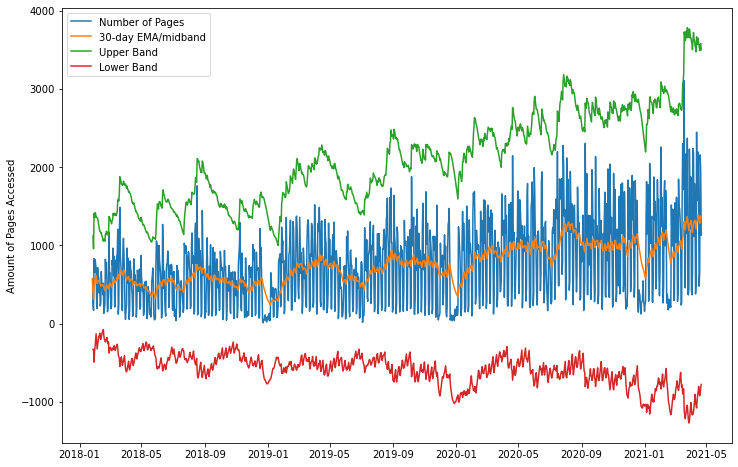

In [29]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(pages.index, pages.pages_accessed, label='Number of Pages')

ax.plot(pages.index, pages.midband, label = '30-day EMA/midband')
ax.plot(pages.index, pages.upper_band, label = 'Upper Band')
ax.plot(pages.index, pages.lower_band, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Amount of Pages Accessed')

plt.show()

### Compute %b